# Seamlessly blend Python and C++ with ROOT

## A powerful Python interface

Most of the core parts of the ROOT software library are developed in C++ to provide efficient and easily scalable execution. Like many other scientific Python packages such as numpy, ROOT can be easily used in Python thanks to a set of language bindings (in this case, between C++ and Python).

## How does it work?

The ROOT Python interface relies on the [cppyy](https://cppyy.readthedocs.io) technology to provide dynamic and automatic bindings that do not require boilerplate code to bridge the two languages. This in turn relies on the C++ interpreter [cling](https://cling.readthedocs.io) to access reflection information and JIT compile the code needed to access the C++ functionalities. In practice, any C++ function or class that can be exposed via the C++ interpreter gets an automatic representation in Python without need for further development or user interaction (see examples below). On top of the automatic bindings, the ROOT project contains custom Python code to enhance C++ features with a Pythonic feeling. All such enhancements are collectively called "pythonizations".

## Using ROOT from Python

ROOT can be used as any other Python module, by importing it.

In [1]:
import ROOT

The ROOT Python module is the entry point for all the ROOT functionality.

For example, we can create a histogram with ROOT using the `TH1D` C++ class from Python:

In [2]:
h = ROOT.TH1D("my_histo", "Example histogram", 100, -4, 4)

## Calling user-defined C++ code in Python

The user can write custom C++ code and access it in their Python application. For example, it is possible to declare a C++ function, as it is done below by passing its code as a string argument of the `Declare` function:

In [3]:
ROOT.gInterpreter.Declare("""
double add(double a, double b) {
    return a + b;
}
""")

ROOT.add(3.14, 100)

103.14

### What about code in C++ libraries?

ROOT also allows calling into code present outside of the same Python application, for example code written in external libraries. This enables you to write high-performance C++, compile it and use it from Python.

More information can be found [here](https://root.cern/manual/python/#loading-user-libraries-and-just-in-time-compilation-jitting).

## Type conversions

When calling C++ code from Python, there is a conversion between the Python arguments we pass and the C++ arguments that the C++ side expects. The ROOT Python interface takes care of such conversion automatically, for example from Python integer to C++ integer:

In [4]:
ROOT.gInterpreter.Declare("void print_integer(int i) { std::cout << i << std::endl; }")

ROOT.print_integer(7)

7


Of course not every conversion is allowed!

In [5]:
ROOT.print_integer([]) # fails with TypeError

TypeError: void print_integer(int i) =>
    TypeError: could not convert argument 1 (int conversion expects an integer object)

An example of a useful allowed conversion is Python list to `std::vector`:

In [6]:
ROOT.gInterpreter.Declare("""
void print_vector(const std::vector<std::string> &v) {
    for (auto &&s : v) {
        std::cout << s << std::endl;
    }
}
""")

ROOT.print_vector(['Two', 'Words'])

Two
Words


## A final note on performance

Being able to call into C++ from Python does not guarantee that the performance of your Python script will always be the best, no matter what code you write!

In general, any heavy computation should be pushed to C++, e.g. encapsulating it in some C++ function that you call from Python or relying on libraries with fast C/C++ implementations (e.g. ROOT, NumPy).

In the context of high-energy physics, iterating over the collision events in a dataset is a common operation. Such iteration in Python can be slow for big datasets and should only be done during short exploratory work. Later in this course we will see how the event loop can be efficiently executed in C++, even from a Python script, with the help of ROOT's [RDataFrame](https://root.cern/doc/master/classROOT_1_1RDataFrame.html).

```python
# This can be slow!
for event in dataset:
    h.Fill(event.field)
```

# ROOT in Jupyter

ROOT can be used in Jupyter notebooks, both in Python and C++. In this course we will focus only on Python, but for people interested in ROOT C++ notebooks some examples can be found [here](https://swan-gallery.web.cern.ch/root_primer/).

There are some specificities and extra features available when running ROOT from a notebook, and that's what will be covered in this section!


## ROOT Graphics in a notebook

There are two modes in which we can visualize ROOT plots in a notebook
* Static images (default)
* Interactive JavaScript displays

To see an example, let's first create a histogram and fill it with random numbers following a Gaussian distribution:

In [7]:
h = ROOT.TH1D("my_histo", "Example histogram", 100, -4, 4)
h.FillRandom("gaus")

Warning in <TROOT::Append>: Replacing existing TH1: my_histo (Potential memory leak).


Now let's plot the histogram. For that purpose, we first need to create a canvas, then draw the histogram and finally draw the canvas. See how the output is a static image.

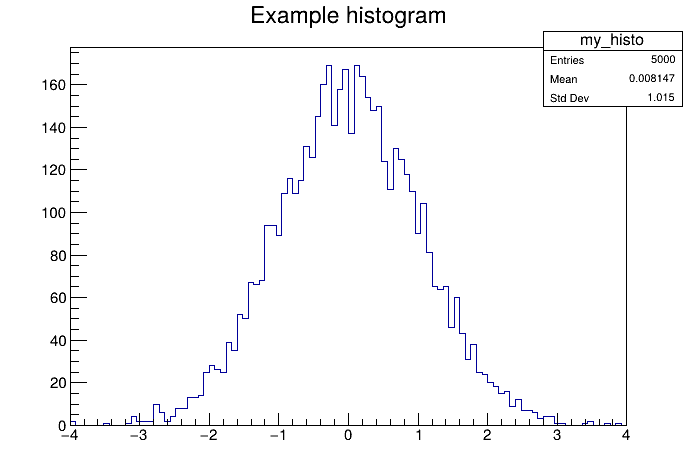

In [8]:
c = ROOT.TCanvas()
h.Draw()
c.Draw() # don't forget to draw the canvas too!

## Shortcut for injecting C++ code in a notebook

In a notebook, we can use the `%%cpp` magic to declare C++ code to the interpreter. If `%%cpp` is present in a cell, its whole content is interpreted and executed as C++, and it has C++ syntax coloring!

In [1]:
%%cpp
void print_integer_2(int i) {
   std::cout << i << std::endl;
}

UsageError: Cell magic `%%cpp` not found.


The function we just defined in the previous (C++) cell can be now invoked from the next (Python) cell:

In [10]:
ROOT.print_integer_2(7)

7


## Redefining C++ entities

In C++, redefinition of entities such as variables is not allowed. However, ROOT provides a cool redefinition feature that is especially useful in interactive interfaces like notebooks. This feature works for types, functions and variables defined in the global namespace.

You can check it by running the next cells, even multiple times!

In [11]:
%%cpp
int foo = 0;

In [12]:
%%cpp
class foo {};

In [13]:
%%cpp
void foo() {}